# Setup

## Importing Libraries

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import os
import time
from datetime import datetime 
import os
import copy
import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Setting default paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data paths
train_csv_file = '/content/drive/MyDrive/final year project/datasets/skin_mnist/final_train.csv'
val_csv_file = '/content/drive/MyDrive/final year project/datasets/skin_mnist/final_val.csv'
test_csv_file = '/content/drive/MyDrive/final year project/datasets/skin_mnist/final_test.csv'

# root path
root_dir = '/content/drive/MyDrive/final year project/datasets/skin_mnist'

## Custom Pytorch Dataset


In [ ]:
# custom pytorch dataset for the SkinMnistDataset 
class SkinMnistDataset(Dataset):
  '''
  csv_file is the csv_file containing the information
  root_dir is the parent directory/folder containing the images
  transforms specifies the transformation to be applied on the images
  '''

  def __init__(self, csv_file, root_dir, transforms=None):
    self.csv_file = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transforms = transforms

  def __len__(self):
    '''
    :return: returns the length of the dataset
    '''
    return len(self.csv_file)
  
  def __getitem__(self, item):
    """
    :param item:it is the the index of the data item to be fetched.
    :return: it returns the specified index dataitem and its corresponding label
    """
    image_path = os.path.join(self.root_dir, self.csv_file['image_path'][item])
    image = Image.open(image_path)
    row = self.csv_file.iloc[item, -3:]
    label = torch.tensor(row)

    if self.transforms:
      image=self.transforms(image)
    return (image, label)


## Data Preprocessing

In [ ]:
#image transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.6373545 , 0.44605875, 0.46191868],[0.27236816, 0.22500427, 0.24329403])
    ]),
    'test': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.6373545 , 0.44605875, 0.46191868], [0.27236816, 0.22500427, 0.24329403])
    ]),
}

In [ ]:
# retrieving images with transformations for training

train_dataset = SkinMnistDataset(train_csv_file, root_dir, data_transforms['train'])
val_dataset = SkinMnistDataset(val_csv_file, root_dir, data_transforms['test'])
test_dataset = SkinMnistDataset(test_csv_file, root_dir,data_transforms['test'])

len(train_dataset), len(val_dataset), len(test_dataset)

(1300, 335, 40)

## Data Loaders

In [ ]:
batch_size = 64
shuffle = True
num_classes = 3

In [ ]:
dataloaders = {
    'train': DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle),
    'val': DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=shuffle),
    'test':DataLoader(dataset=test_dataset, batch_size=batch_size)
    }

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test':len(test_dataset)
}

In [ ]:
len(dataloaders['test'].dataset)

40

## Image plotting function

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6373545 , 0.44605875, 0.46191868])
    std = np.array([0.27236816, 0.22500427, 0.24329403])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



## Initializing Pretrained Model

In [ ]:
def set_parameter_requires_grad(model, num_freeze):
  for i, param in enumerate(model.parameters()):
    if i >= num_freeze:
      break
    param.requires_grad = False

In [ ]:
model_ft = models.vgg16_bn(pretrained=True)
set_parameter_requires_grad(model_ft,20)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
inputs_size = 224
# num_ftrs

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for i,(name,parameter) in enumerate(model_ft.named_parameters()):
    
    print(i,name)
model_ft.parameters

0 features.0.weight
1 features.0.bias
2 features.1.weight
3 features.1.bias
4 features.3.weight
5 features.3.bias
6 features.4.weight
7 features.4.bias
8 features.7.weight
9 features.7.bias
10 features.8.weight
11 features.8.bias
12 features.10.weight
13 features.10.bias
14 features.11.weight
15 features.11.bias
16 features.14.weight
17 features.14.bias
18 features.15.weight
19 features.15.bias
20 features.17.weight
21 features.17.bias
22 features.18.weight
23 features.18.bias
24 features.20.weight
25 features.20.bias
26 features.21.weight
27 features.21.bias
28 features.24.weight
29 features.24.bias
30 features.25.weight
31 features.25.bias
32 features.27.weight
33 features.27.bias
34 features.28.weight
35 features.28.bias
36 features.30.weight
37 features.30.bias
38 features.31.weight
39 features.31.bias
40 features.34.weight
41 features.34.bias
42 features.35.weight
43 features.35.bias
44 features.37.weight
45 features.37.bias
46 features.38.weight
47 features.38.bias
48 features.40

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

# Training

In [ ]:
run = 5
run_path = f'/content/drive/MyDrive/final year project/models/vgg16_bn/run{run}'
if os.path.isdir(run_path):
  print("This run was already completed, please specify a different run if wanna start again")
else: 
  os.makedirs(run_path)
  os.makedirs(os.path.join(run_path, 'checkpoints'))
best_model_path = f'/content/drive/MyDrive/final year project/models/vgg16_bn/run{run}/best_model_vgg16_bn.pt'
checkpoint_dir = f'/content/drive/MyDrive/final year project/models/vgg16_bn/run{run}/checkpoints/'

This run was already completed, please specify a different run if wanna start again


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, start_epoch=0, num_epochs=25, best_acc=0.0, hist={'val_acc': False, 'train_acc': False} ):
    since = time.time()

    val_acc_history = hist['val_acc'] or []
    train_acc_history = hist['train_acc'] or []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = best_acc

    for epoch in range(start_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # print('beginning of forwardprop')                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                  # Get model outputs and calculate loss
                  
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, torch.max(labels, 1)[1])


                  # print('beginning of backprop')
                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
                  # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.max(labels, 1)[1].data)
            if phase == 'val':
              # print('LR Decreased')
              print('LR', optimizer.param_groups[0]['lr'])
              scheduler.step(loss)
      
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Saving as best model*******************************')
                torch.save( model.state_dict(),
                 best_model_path)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
            if phase == 'val':
              val_acc_history.append(epoch_acc)
              if epoch % 4 == 0:
                print("Saving Checkpoint")
                print("Best Acc", best_acc.item())
                torch.save({
                    "epoch": epoch,
                    "loss": loss,
                    "model_state_dict": model.state_dict(),
                    "best_acc": best_acc,
                    "hist": {'val_acc':val_acc_history, 'train_acc': train_acc_history}
                }, os.path.join(checkpoint_dir, 'Epoch={0:0=3d}.pt'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'val_acc':val_acc_history, 'train_acc': train_acc_history}

## Instatiate Optimizer and Scheduler and pass in only trainable parameters

In [ ]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Parameters to Learn:")

params_to_update = []
for name, param in model_ft.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    # print('\t', name)
print(len(params_to_update))
optimizer_ft = optim.Adam(params_to_update, lr=0.001)
# optimizer_ft = optim.SGD(params_to_update, lr=0.005, momentum=0.9,nesterov=True)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min',
    factor=0.25, patience=1, verbose=True,
    threshold=0.0001, threshold_mode='rel',
    cooldown=0, min_lr=0, eps=1e-08
)

Parameters to Learn:
38


In [ ]:
criterion = nn.CrossEntropyLoss()

num_epochs = 51
best_acc = 0.0
start_epoch = 0
hist = {'val_acc': False, 'train_acc': False}

checkpoints = os.listdir(path=checkpoint_dir)

if len(checkpoints):
  print(f"Getting the latest checkpoint in run{run}: ")
  name = checkpoints[-1]
  print(f"Loading Checkpoint file: {name}")
  checkpoint_path = os.path.join(checkpoint_dir, name)
  checkpoint = torch.load(checkpoint_path)
  best_acc = checkpoint['best_acc']
  model_ft.load_state_dict(checkpoint['model_state_dict']) 
  hist = checkpoint['hist']
  print(f'{name} loaded successfully')
  start_epoch = checkpoint['epoch'] + 1
  print(f"{start_epoch} epochs done already")
  print(f'traning for {num_epochs - start_epoch} more epochs')
else:
  print('training from scratch')

training from scratch


## Training loop

In [ ]:
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, 
                              scheduler=exp_lr_scheduler,
                              num_epochs=num_epochs,
                              start_epoch=start_epoch,
                              best_acc=best_acc,
                              hist=hist
                             )

Epoch 0/50
----------
train Loss: 0.9721 Acc: 0.5438
LR 0.001
val Loss: 1.4022 Acc: 0.4388
Saving as best model*******************************
Saving Checkpoint
Best Acc 0.4388059701492537

Epoch 1/50
----------
train Loss: 0.7607 Acc: 0.6562
LR 0.001
val Loss: 2.3730 Acc: 0.5910
Saving as best model*******************************

Epoch 2/50
----------
train Loss: 0.7891 Acc: 0.6708
LR 0.001
val Loss: 1.0603 Acc: 0.6299
Saving as best model*******************************

Epoch 3/50
----------
train Loss: 0.6975 Acc: 0.7023
LR 0.001
val Loss: 1.4032 Acc: 0.5194

Epoch 4/50
----------
train Loss: 0.6947 Acc: 0.7123
LR 0.001
val Loss: 0.9026 Acc: 0.6358
Saving as best model*******************************
Saving Checkpoint
Best Acc 0.6358208955223881

Epoch 5/50
----------
train Loss: 0.6754 Acc: 0.7200
LR 0.001
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
val Loss: 0.7621 Acc: 0.7045
Saving as best model*******************************

Epoch 6/50
----------
train Loss: 

In [ ]:
stats =  {
  'training_time': '35m 9s',
  'val_acc': 0.8000,
  'train_acc': 0.7762,
  'optmizer': 'Adam',
  'initial_lr': 0.005,
  'layers_frozen': 20,
  'momentum': 0.9,
  'patience': 1,
  'factor': 0.5,
  'epoch':26,
  'train_loss':  0.5380 ,  
  "LR" :7.8125e-06,
  'val_loss': 0.5366
}
stats_df = pd.DataFrame.from_dict(stats, orient='index')

In [ ]:
stats_df.to_csv(os.path.join(run_path, 'best_stats.csv'))

In [ ]:
checkpoint_dir

'/content/drive/MyDrive/final year project/models/vgg16_bn/run5/checkpoints/'

In [ ]:
loss_vs_time=[]
checkpoints=os.listdir(path=checkpoint_dir)
for checkpoint_name in checkpoints:
  checkpoint=torch.load(checkpoint_dir+checkpoint_name)
  loss=checkpoint['loss']
  loss_vs_time.append(loss)

In [ ]:
loss_vs_time

[tensor(1.3166, device='cuda:0'),
 tensor(0.9191, device='cuda:0'),
 tensor(0.9552, device='cuda:0'),
 tensor(0.5964, device='cuda:0'),
 tensor(0.3454, device='cuda:0'),
 tensor(0.7729, device='cuda:0'),
 tensor(0.3160, device='cuda:0'),
 tensor(0.4831, device='cuda:0'),
 tensor(0.6858, device='cuda:0'),
 tensor(0.6811, device='cuda:0'),
 tensor(0.7283, device='cuda:0'),
 tensor(0.7887, device='cuda:0'),
 tensor(0.4871, device='cuda:0')]

In [ ]:
result = [tensor.item() for tensor in loss_vs_time]
print(type(result[0]))
print(result)

<class 'float'>
[1.3166109323501587, 0.9190925359725952, 0.9552081227302551, 0.59638911485672, 0.34541863203048706, 0.7728977799415588, 0.316037118434906, 0.4831375181674957, 0.6857671737670898, 0.6811023950576782, 0.7283161282539368, 0.7887415289878845, 0.4870621860027313]


Text(0, 0.5, 'Epoch')

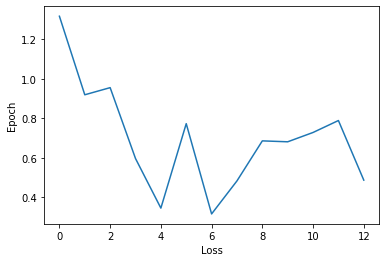

In [ ]:
plt.plot(result)
plt.xlabel('Loss')
plt.ylabel('Epoch')

In [ ]:
# var startClickConnect = function startClickConnect(){
#     var clickConnect = function clickConnect(){
#         console.log("Connnect Clicked - Start");
#         document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
#         console.log("Connnect Clicked - End"); 
#     };

#     var intervalId = setInterval(clickConnect, 60000);

#     var stopClickConnectHandler = function stopClickConnect() {
#         console.log("Connnect Clicked Stopped - Start");
#         clearInterval(intervalId);
#         console.log("Connnect Clicked Stopped - End");
#     };

#     return stopClickConnectHandler;
# };

# var stopClickConnect = startClickConnect();

# Inference


## Loading the best model


In [ ]:
for i,j in dataloaders['test']:
    print(model_ft(i.to(device)),torch.max(j,1)[1])
    break
len(dataloaders['test'])
# dataloaders['test']

tensor([[-2.8441,  3.9006, -1.5549],
        [-0.3481, -0.1899,  0.6163],
        [-0.7961,  1.1196, -0.4119],
        [-2.3060,  1.8603,  0.3360],
        [ 5.2342, -3.2703, -1.6613],
        [ 0.0298,  0.2673, -0.2986],
        [10.0433, -6.1894, -3.1983],
        [ 0.6975, -0.7133,  0.0737],
        [ 0.2781,  0.1588, -0.3911],
        [ 0.4394, -0.6901,  0.2988],
        [-1.3783,  0.3916,  0.9904],
        [ 0.1633, -0.4056,  0.3146],
        [ 8.6761, -5.2976, -2.7864],
        [-1.0427,  1.2749, -0.2888],
        [ 7.0231, -4.3950, -2.1858],
        [ 0.5233, -1.3397,  0.8683],
        [-2.5572,  3.7434, -1.6458],
        [ 8.4467, -5.0853, -2.7605],
        [-1.6474,  0.9722,  0.6512],
        [ 4.0117, -2.4407, -1.2559],
        [-0.0183, -0.8020,  0.8680],
        [-1.3941,  2.1698, -1.0131],
        [-1.2120,  0.3863,  0.8317],
        [ 1.5065, -1.5703,  0.1561],
        [ 9.6888, -5.7937, -3.1692],
        [-0.0236, -0.8463,  0.9167],
        [ 0.2463, -1.7160,  1.5068],
 

1

In [ ]:
criterion(torch.tensor([[ 1.6236, -1.4953,  0.0344]]),torch.tensor([2]), )

tensor(1.8110)

In [ ]:
model_ft.load_state_dict(torch.load(best_model_path))
model_ft.eval()

def inference(dataloaders, criterion):

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = torch.max(labels, 1)[1]
     
        outputs = model_ft(inputs)
        preds = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss / len(dataloaders['test'])
    test_acc = running_corrects.double() / dataset_sizes['test']

    print('Test Results:\n Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))
    return preds, test_loss, test_acc 

In [ ]:
preds, loss, acc = inference(dataloaders,criterion)

Test Results:
 Loss: 0.4979 Acc: 0.7750
